# Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import matplotlib

# Color palette

In [2]:
blue = [0.229999504, 0.298998934, 0.754000139]
red = [0.706000136, 0.015991824, 0.150000072]

# Extended Data Figure 1a

(-1.0, 1.0)

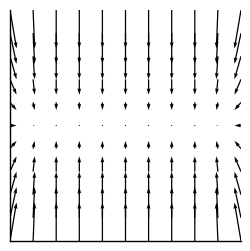

In [3]:
fig, ax = plt.subplots(figsize=(3, 3))

resolution = 11
x_, y_ = np.meshgrid(
    np.linspace(-1, 1, num=resolution), 
    np.linspace(-1, 1, num=resolution)
)

u_ = np.zeros_like(x_)
v_ = np.zeros_like(y_)
u_left_ = np.zeros_like(x_)
v_left_ = np.zeros_like(y_)
u_right_ = np.zeros_like(x_)
v_right_ = np.zeros_like(y_)

for i in range(resolution):
    for j in range(resolution):
        if x_[i, j] >= 0.7 or x_[i, j] <= -0.7:
            u_[i, j] = 1/3 * x_[i, j] * (0.49 - x_[i, j]**2)
            v_[i, j] = -1*y_[i, j]
        else:
            u_[i, j] = 0
            v_[i, j] = -1*y_[i, j]
        u_left_[i, j] = -1
        v_left_[i, j] = 0
        u_right_[i, j] = 1
        v_right_[i, j] = 0

ax.set_aspect('equal')
ax.quiver(x_, y_, u_, v_, angles='xy', scale_units='xy', scale=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Extended Data Figure 1b

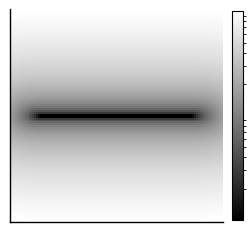

In [4]:
fig, ax = plt.subplots(figsize=(3, 3))

resolution = 110
x, y = np.meshgrid(
    np.linspace(-1, 1, num=resolution), 
    np.linspace(-1, 1, num=resolution)
)

u = np.zeros_like(x)
v = np.zeros_like(y)
u_left = np.zeros_like(x)
v_left = np.zeros_like(y)
u_right = np.zeros_like(x)
v_right = np.zeros_like(y)
energy = np.zeros_like(x)
energy_input = np.zeros_like(x)

for i in range(resolution):
    for j in range(resolution):
        if x[i, j] >= 0.7 or x[i, j] <= -0.7:
            u[i, j] = 1/3 * x[i, j] * (0.49 - x[i, j]**2)
            v[i, j] = -1*y[i, j]
        else:
            u[i, j] = 0
            v[i, j] = -1*y[i, j]
        energy[i, j] = np.sqrt(u[i, j]**2 + v[i, j]**2)      
        
ax.set_aspect('equal')
c1 = ax.pcolormesh(
    x,
    y,
    energy, 
    cmap='gray', 
    norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1)
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

cbar = fig.colorbar(c1, ax=ax, fraction=0.045, pad=0.04)
cbar.ax.set_yscale('log')
cbar.ax.set_yticks([])
cbar.ax.tick_params(labelsize=25)

# Generate click stimuli

In [5]:
np.random.seed(1)
nsimtrials = 10000
gammas = np.random.choice([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5], size=nsimtrials)
rL = 40/(1 + np.exp(gammas))
rR = 40/(1 + np.exp(-gammas))

phi = 1e-3
k = 100
clicks = np.zeros((nsimtrials, 100, 2))

for trial in range(nsimtrials):
    leftclicktimes = np.cumsum(np.random.exponential(scale=1/rL[trial], size=100))
    leftclicktimes = leftclicktimes[leftclicktimes <= 1]
    leftclicktimes = np.insert(leftclicktimes, 0, 0)
    rightclicktimes = np.cumsum(np.random.exponential(scale=1/rR[trial], size=100))
    rightclicktimes = rightclicktimes[rightclicktimes <= 1]
    rightclicktimes = np.insert(rightclicktimes, 0, 0)
    clicktimes = np.sort(np.hstack((leftclicktimes, rightclicktimes)))[1:]
    adapted_clicks = np.zeros_like(clicktimes)
    adapted_clicks[0] = 1.0 - (1.0-phi)*np.exp(-k*clicktimes[0])

    for i in range(1, len(clicktimes)):
        delta_t = clicktimes[i] - clicktimes[i-1]
        adapted_clicks[i] = 1.0 - (1.0-phi*adapted_clicks[i-1])*np.exp(-k*delta_t)

    leftindex = [i for i, x in enumerate(clicktimes) if x in leftclicktimes]
    rightindex = [i for i, x in enumerate(clicktimes) if x in rightclicktimes]

    left_adapted_clicks = adapted_clicks[leftindex]
    right_adapted_clicks = adapted_clicks[rightindex]
    
    t_end = np.random.choice([50, 70, 90])

    for t in range(t_end):
        left_click_indx = (0.01*t <= leftclicktimes) & (leftclicktimes < 0.01*(t+1))
        right_click_indx = (0.01*t <= rightclicktimes) & (rightclicktimes < 0.01*(t+1))
        cL = np.sum(left_adapted_clicks[left_click_indx])
        cR = np.sum(right_adapted_clicks[right_click_indx])
        clicks[trial, t, 0] = cL
        clicks[trial, t, 1] = cR
clicks[:, 0, :] = 0
cweight = np.array([[-1, 1], [0, 0]]) / 40

latent = np.zeros((nsimtrials, 100, 2))
noise = 0.005
dt = 0.01
for trial in range(nsimtrials):
    for time in range(99):
        if (latent[trial , time, 0] >= 0.7) or (latent[trial , time, 0] <= -0.7):
            latent[trial, time+1, :] = latent[trial , time, :] + dt * np.array(
                [10*latent[trial , time, 0] * (0.49 - latent[trial , time, 0]**2), -30 * latent[trial , time, 1]]) + noise * np.random.randn(2)
        else:
            latent[trial, time+1, :] = latent[trial , time, :] + dt * np.array(
                [0., -30 * latent[trial , time, 1]]) + clicks[trial, time, :] @ cweight.T + noise * np.random.randn(2)

In [6]:
resolution = 110
x, y = np.meshgrid(
    np.linspace(-1, 1, num=resolution), 
    np.linspace(-0.2, 0.2, num=resolution)
)

z_pc_flat_ = np.reshape(latent[:,:100,:], (-1, 2))
leftclicks = np.reshape(clicks[:,:,0], -1) # left clicks
leftclicks = leftclicks > 0

rightclicks = np.reshape(clicks[:,:,1], -1) # right clicks
rightclicks = rightclicks > 0

z_pc_flat = np.reshape(latent, (-1, 2))
leftclick_locs = z_pc_flat[leftclicks, :]
rightclick_locs = z_pc_flat[rightclicks, :]

counts_leftclick,xbins,ybins = np.histogram2d(
    leftclick_locs[:, 0], 
    leftclick_locs[:, 1],
    bins=resolution,
    range=[[-1, 1], [-0.2, 0.2]]
)

counts_rightclick,xbins,ybins = np.histogram2d(
    rightclick_locs[:, 0], 
    rightclick_locs[:, 1],
    bins=resolution,
    range=[[-1, 1], [-0.2, 0.2]]
)

counts,xbins,ybins = np.histogram2d(
    z_pc_flat_[:, 0], 
    z_pc_flat_[:, 1],
    bins=resolution,
    range=[[-1, 1], [-0.2, 0.2]]
)

p_lc = counts_leftclick/counts
p_rc = counts_rightclick/counts
p_lc[np.isnan(p_lc)] = 0
p_rc[np.isnan(p_rc)] = 0

u = np.zeros_like(x)
v = np.zeros_like(y)
u_left = np.zeros_like(x)
v_left = np.zeros_like(y)
u_right = np.zeros_like(x)
v_right = np.zeros_like(y)
energy = np.zeros_like(x)
energy_left = np.zeros_like(x)
energy_right = np.zeros_like(x)
w = np.zeros_like(x)
w_left = np.zeros_like(x)
w_right = np.zeros_like(x)

for i in range(resolution):
    for j in range(resolution):
        uv_left = np.array([-1/40, 0])
        energy_left[i, j] = np.linalg.norm(uv_left)
        u_left[i, j] = uv_left[0]
        v_left[i, j] = uv_left[1]

for i in range(resolution):
    for j in range(resolution):
        uv_right = [1/40, 0]
        energy_right[i, j] = np.linalg.norm(uv_right)
        u_right[i, j] = uv_right[0]
        v_right[i, j] = uv_right[1]


# Flow field
resolution = 11
x_, y_ = np.meshgrid(
    np.linspace(-1, 1, num=resolution), 
    np.linspace(-0.2, 0.2, num=resolution)
)

z_pc_flat_ = np.reshape(latent[:,:100,:], (-1, 2))
leftclicks = np.reshape(clicks[:,:,0], -1) # left clicks
leftclicks = leftclicks > 0

rightclicks = np.reshape(clicks[:,:,1], -1) # right clicks
rightclicks = rightclicks > 0

z_pc_flat = np.reshape(latent, (-1, 2))
leftclick_locs = z_pc_flat[leftclicks, :]
rightclick_locs = z_pc_flat[rightclicks, :]

counts_leftclick,xbins,ybins = np.histogram2d(
    leftclick_locs[:, 0], 
    leftclick_locs[:, 1],
    bins=resolution,
    range=[[-1 - 1/10, 1 + 1/10], [0.2*(-1 - 1/10), 0.2*(1 + 1/10)]]
)

counts_rightclick,xbins,ybins = np.histogram2d(
    rightclick_locs[:, 0], 
    rightclick_locs[:, 1],
    bins=resolution,
    range=[[-1 - 1/10, 1 + 1/10], [0.2*(-1 - 1/10), 0.2*(1 + 1/10)]]
)

counts,xbins,ybins = np.histogram2d(
    z_pc_flat_[:, 0], 
    z_pc_flat_[:, 1],
    bins=resolution,
    range=[[-1 - 1/10, 1 + 1/10], [0.2*(-1 - 1/10), 0.2*(1 + 1/10)]]
)

p_lc_ = counts_leftclick/counts
p_rc_ = counts_rightclick/counts
p_lc_[np.isnan(p_lc_)] = 0
p_rc_[np.isnan(p_rc_)] = 0

u_ = np.zeros_like(x_)
v_ = np.zeros_like(y_)
u_left_ = np.zeros_like(x_)
v_left_ = np.zeros_like(y_)
u_right_ = np.zeros_like(x_)
v_right_ = np.zeros_like(y_)
energy_ = np.zeros_like(x_)
energy_left_ = np.zeros_like(x_)
energy_right_ = np.zeros_like(x_)
w_ = np.zeros_like(x_)
w_left_ = np.zeros_like(x_)
w_right_ = np.zeros_like(x_)

for i in range(resolution):
    for j in range(resolution):
        uv_left = np.array([-1/40, 0])
        energy_left_[i, j] = np.linalg.norm(uv_left)
        u_left_[i, j] = uv_left[0]
        v_left_[i, j] = uv_left[1]

for i in range(resolution):
    for j in range(resolution):
        uv_right = np.array([1/40, 0])
        energy_right_[i, j] = np.linalg.norm(uv_right)
        u_right_[i, j] = uv_right[0]
        v_right_[i, j] = uv_right[1]

/var/folders/jn/x2x9w_8n77b_g5cnyyfbzc9w0000gp/T/ipykernel_7987/580491618.py:39: RuntimeWarning: invalid value encountered in divide
  p_lc = counts_leftclick/counts
/var/folders/jn/x2x9w_8n77b_g5cnyyfbzc9w0000gp/T/ipykernel_7987/580491618.py:40: RuntimeWarning: invalid value encountered in divide
  p_rc = counts_rightclick/counts
/var/folders/jn/x2x9w_8n77b_g5cnyyfbzc9w0000gp/T/ipykernel_7987/580491618.py:111: RuntimeWarning: invalid value encountered in divide
  p_lc_ = counts_leftclick/counts
/var/folders/jn/x2x9w_8n77b_g5cnyyfbzc9w0000gp/T/ipykernel_7987/580491618.py:112: RuntimeWarning: invalid value encountered in divide
  p_rc_ = counts_rightclick/counts


In [7]:
# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.copper_r(np.linspace(0., 1, 128))
colors2 = plt.cm.gray(np.linspace(0, 1, 128))

# combine them and build a new colormap
colors_ = np.vstack((colors1, colors2))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colors_)

cmap1 = colors.ListedColormap(['black'])
colors1 = cmap1(np.linspace(0, 1, 30))
colors2 = plt.cm.copper(np.linspace(0, 1, 128))

colors_ = np.vstack((colors1, colors2))
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap2', colors_)

from scipy.ndimage.filters import gaussian_filter
M = gaussian_filter(p_lc.T, sigma=7) + 0.001
M1=M.reshape(11,10,11,10)
M2=M1.mean(axis=(1,3))
p_lc_m = M2.T

M = gaussian_filter(p_rc.T, sigma=7) + 0.001
M1=M.reshape(11,10,11,10)
M2=M1.mean(axis=(1,3))
p_rc_m = M2.T

/var/folders/jn/x2x9w_8n77b_g5cnyyfbzc9w0000gp/T/ipykernel_7987/1675027636.py:17: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


# Extended Data Figure 1c

(-1.0, 1.0)

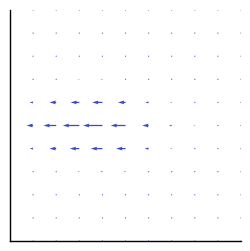

In [8]:
fig, ax = plt.subplots(figsize=(3, 3))

cweight = np.array([[-1, 1], [0, 0]])/4
clickperturb = np.array([1, 0]) @ cweight.T

resolution = 11
x_, y_ = np.meshgrid(
    np.linspace(-1, 1, num=resolution), 
    np.linspace(-1, 1, num=resolution)
)

u_ = np.zeros_like(x_)
v_ = np.zeros_like(y_)
u_left_ = np.zeros_like(x_)
v_left_ = np.zeros_like(y_)
u_right_ = np.zeros_like(x_)
v_right_ = np.zeros_like(y_)

for i in range(resolution):
    for j in range(resolution):
        u_[i, j] = clickperturb[0]
        v_[i, j] = clickperturb[1]

ax.set_aspect('equal')
ax.quiver(x_, y_, u_*p_lc_m.T, v_*p_lc_m.T, angles='xy', scale_units='xy', scale=0.2, color=blue)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Extended Data Figure 1d

(-1.0, 1.0)

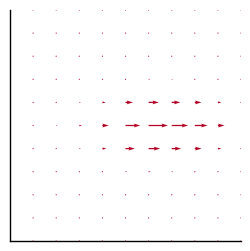

In [9]:
fig, ax = plt.subplots(figsize=(3, 3))

cweight = np.array([[-1, 1], [0, 0]])/4
clickperturb = np.array([1, 0]) @ cweight.T

resolution = 11
x_, y_ = np.meshgrid(
    np.linspace(-1, 1, num=resolution), 
    np.linspace(-1, 1, num=resolution)
)

u_ = np.zeros_like(x_)
v_ = np.zeros_like(y_)
u_left_ = np.zeros_like(x_)
v_left_ = np.zeros_like(y_)
u_right_ = np.zeros_like(x_)
v_right_ = np.zeros_like(y_)

for i in range(resolution):
    for j in range(resolution):
        u_[i, j] = clickperturb[0]
        v_[i, j] = clickperturb[1]

ax.set_aspect('equal')
ax.quiver(-x_, y_, -u_*p_lc_m.T, v_*p_lc_m.T, angles='xy', scale_units='xy', scale=0.2, color=red)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Extended Data Figure 1e

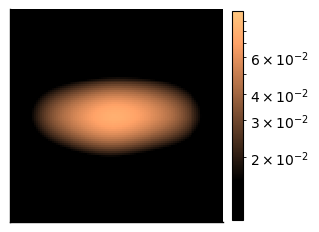

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))

resolution = 110
x, y = np.meshgrid(
    np.linspace(-1, 1, num=resolution), 
    np.linspace(-1, 1, num=resolution)
)
     
ax.set_aspect('equal')
c1 = ax.pcolormesh(
    x,
    y,
    gaussian_filter((p_lc.T + p_rc.T)/2, sigma=10) + 0.001, 
    cmap=mymap2, 
    norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=0.1)
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

cbar = fig.colorbar(c1, ax=ax, fraction=0.045, pad=0.04)
cbar.ax.set_yscale('log')
cbar.ax.set_yticks([])
cbar.ax.tick_params(labelsize=25)

# Extended Data Figure 1g

## Define color maps

In [11]:
import csv

scw = []

with open('../../data/processed_data/common/smooth-cool-warm-table-float-1024.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for i, rows in enumerate(reader):
        if i > 0:
            r = [float(i) for i in rows]
            scw.append(tuple(r[1:]))
            scw.append(r[0])
            
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = list(seq) + [(None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return colors.LinearSegmentedColormap('CustomMap', cdict)

c = colors.ColorConverter().to_rgb
rvb = make_colormap(scw)
cmap = rvb

## Load fits from FINDR

In [12]:
data = np.load("../../data/processed_data/extended_data_figure_1/ddmlineattractor.npz")
x = data['x']
y = data['y']
u = data['u']
v = data['v']
w = data['w']
energy = data['energy']
x_ = data['x_']
y_ = data['y_']
u_ = data['u_']
v_ = data['v_']
w_ = data['w_']
energy_ = data['energy_']
u_left = data['u_left']
v_left = data['v_left']
w_left = data['w_left']
energy_left = data['energy_left']
u_right = data['u_right']
v_right = data['v_right']
w_right = data['w_right']
energy_right = data['energy_right']
u_left_ = data['u_left_']
v_left_ = data['v_left_']
w_left_ = data['w_left_']
energy_left_ = data['energy_left_']
u_right_ = data['u_right_']
v_right_ = data['v_right_']
w_right_ = data['w_right_']
energy_right_ = data['energy_right_']   
p_lc = data['p_lc']
p_rc = data['p_rc']
p_lc_ = data['p_lc_']
p_rc_ = data['p_rc_']
z_pc_ = data['z_pc_']
gammas = np.load("../../data/processed_data/common/gammas.npy")

## Generate plot

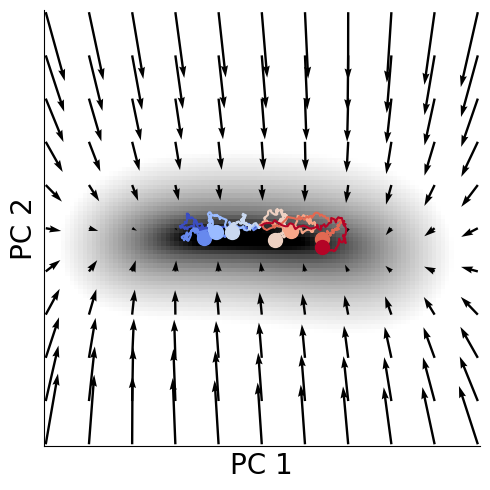

In [13]:
flip_horizontally = -1
flip_vertically = 1

fig, ax = plt.subplots(1, figsize=(5, 5))

xrange = -6*min(
    np.round(np.min(z_pc_[:,0]).item()), np.round(np.max(z_pc_[:,0]).item())
)/4

evidences = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5] # in gamma

# compute the evidence-conditioned average trajectories
avg_trajectories = [np.mean(z_pc_[(gammas == evidences[i]),:,:], axis=0) for i in range(len(evidences))]
norm = colors.Normalize(vmin=-3.5, vmax=3.5)

ax.quiver(
    flip_horizontally * x_/xrange, 
    flip_vertically * y_/xrange, 
    flip_horizontally * u_/xrange, 
    flip_vertically * v_/xrange, 
    angles='xy', color='black', scale_units='xy', scale=15, zorder=150
)

ax.pcolormesh(
    flip_horizontally * x/xrange, 
    flip_vertically * y/xrange, 
    energy, 
    cmap='gray', 
    norm=colors.LogNorm(vmin=0.1, vmax=1)
)

for i in range(len(evidences)):
    ax.plot(
        flip_horizontally * avg_trajectories[i][:, 0]/xrange, 
        flip_vertically * avg_trajectories[i][:, 1]/xrange, 
        '-', color=cmap(norm(evidences[i])), zorder=1100
    )
    ax.plot(
        [flip_horizontally * avg_trajectories[i][-1, 0]/xrange], 
        [flip_vertically * avg_trajectories[i][-1, 1]/xrange], 
        'o', markersize=10, color=cmap(norm(evidences[i])), zorder=1100
    )

ax.set_ylabel("PC 2", fontsize=20)
ax.set_xlabel("PC 1", fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()